<a href="https://colab.research.google.com/github/junhyunpark0126/property-attributes-prediction/blob/main/PropertyAttributesPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning : Predicting the Attributes of Properties


### Imports/Setup


In [1]:
# import packages
import json
import glob
import pandas as pd
import numpy as np
import datetime as dt
import re
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from google.colab import drive
from sklearn.model_selection import train_test_split
from collections import Counter
import seaborn as sns

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
%%capture
!apt update
!pip install kaggle

# **Part I:** Preprocessing and Modeling in `scikit-learn`

## **1.1** Data Loading and Preprocessing

### **1.1.1** Read and Load Data

We are using one CSV `properties_data.csv` from a Kaggle [dataset](https://www.kaggle.com/datasets/dataregress/dubai-properties-dataset/data). The dataset contains 38 columns and over 1900 property entries.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/

In [6]:
# Download dataset
!!kaggle datasets download -d dataregress/dubai-properties-dataset

['Downloading dubai-properties-dataset.zip to /content',
 '',
 '  0% 0.00/60.0k [00:00<?, ?B/s]',
 '',
 '100% 60.0k/60.0k [00:00<00:00, 59.9MB/s]']

In [7]:
# Unzip folder in Colab content folder
!unzip /content/dubai-properties-dataset.zip

Archive:  /content/dubai-properties-dataset.zip
  inflating: properties_data.csv     


In [8]:
df_properties = pd.read_csv("properties_data.csv")

## **1.2** EDA


### **1.2.1** Visualization [12 points]

#### (a) Examining Neighborhood and Quality

For the ***top ten neighborhoods with the most properties***, we want to find the number of Low, Medium, High, Ultra listings from the `quality` column.

In [9]:
df_temp = df_properties.groupby('neighborhood').agg({'price': 'count'}).reset_index()
df_temp = df_temp.sort_values(by='price', ascending=False)

top_ten_neighborhoods = df_temp['neighborhood'].head(10).to_list()

In [10]:
ten_neighborhoods_df = df_properties[df_properties['neighborhood'].isin(top_ten_neighborhoods)]

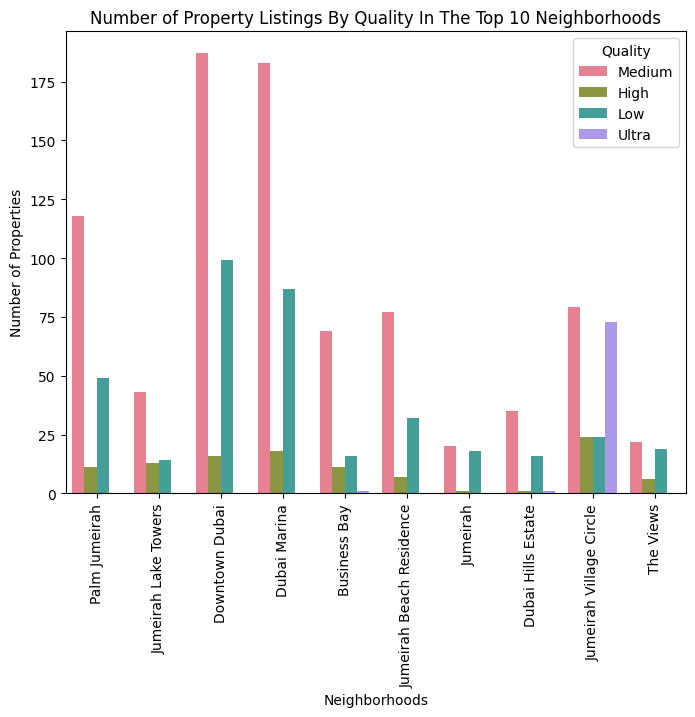

In [11]:
plt.figure(figsize=(8,6))
sns.countplot(data=ten_neighborhoods_df, x='neighborhood', hue='quality', palette='husl')
plt.title('Number of Property Listings By Quality In The Top 10 Neighborhoods')
plt.xlabel('Neighborhoods')
plt.ylabel('Number of Properties')
plt.legend(title='Quality')
plt.xticks(rotation=90)

plt.show()

#### (b) 3D Scatterplot

We want to examine the relationship between three variables: `number_of_bedrooms`, `number_of_bathrooms`, and `price`. We also want to examine `quality` as well.

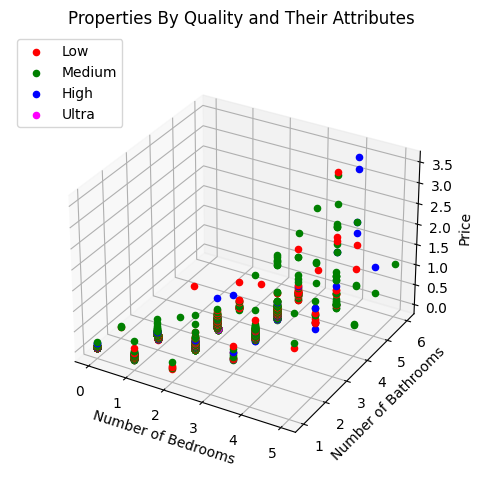

In [12]:
import matplotlib.pyplot as plt

# save the corresponding series from dataframe into lists/containers
number_of_bedrooms = df_properties['no_of_bedrooms'].to_list()
number_of_bathrooms = df_properties['no_of_bathrooms'].to_list()
price = df_properties['price'].to_list()
quality = df_properties['quality'].to_list()

# create a 3D scatter plot of size (6,6)
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')

# create a dictionary with your quality and corresponding colors
color_dict = {
    'Low' : 'red',
    'Medium' : 'green',
    'High' : 'blue',
    'Ultra' : 'magenta'
}

# iterate through and plot datapoints

for i in range(len(quality)):
  ax.scatter(number_of_bedrooms[i], number_of_bathrooms[i], price[i], color=color_dict[quality[i]], marker='o')


# set title and labels

ax.set_title('Properties By Quality and Their Attributes')
ax.set_xlabel('Number of Bedrooms')
ax.set_ylabel('Number of Bathrooms')
ax.set_zlabel('Price')
ax.set_box_aspect(aspect=None, zoom=0.85)

for quality, color in color_dict.items():
    ax.scatter([], [], [], c=color, marker='o', label=quality)
ax.legend(loc='upper left')
plt.show()

### **1.2.2** Correlation of Feature Variables

_**Isolating Numerics from Categorical Features**_

In [13]:
temp_df1 = df_properties.select_dtypes(include=['int64', 'float64'])
temp_df1 = temp_df1.drop(['id', 'latitude', 'longitude', 'price'], axis=1)
temp_df2 = df_properties.select_dtypes(include=['bool', 'object'])
temp_df2 = temp_df2.drop(['quality'], axis=1)

In [14]:
num_df = temp_df1.sort_index(axis=1, ascending=True)
cat_df = temp_df2.sort_index(axis=1, ascending=True)

In [15]:
num_df.columns

Index(['no_of_bathrooms', 'no_of_bedrooms', 'price_per_sqft', 'size_in_sqft'], dtype='object')

In [16]:
cat_df.columns

Index(['balcony', 'barbecue_area', 'built_in_wardrobes', 'central_ac',
       'childrens_play_area', 'childrens_pool', 'concierge', 'covered_parking',
       'kitchen_appliances', 'lobby_in_building', 'maid_room', 'maid_service',
       'neighborhood', 'networked', 'pets_allowed', 'private_garden',
       'private_gym', 'private_jacuzzi', 'private_pool', 'security',
       'shared_gym', 'shared_pool', 'shared_spa', 'study', 'unfurnished',
       'vastu_compliant', 'view_of_landmark', 'view_of_water',
       'walk_in_closet'],
      dtype='object')

_**Correlation Heatmap**_

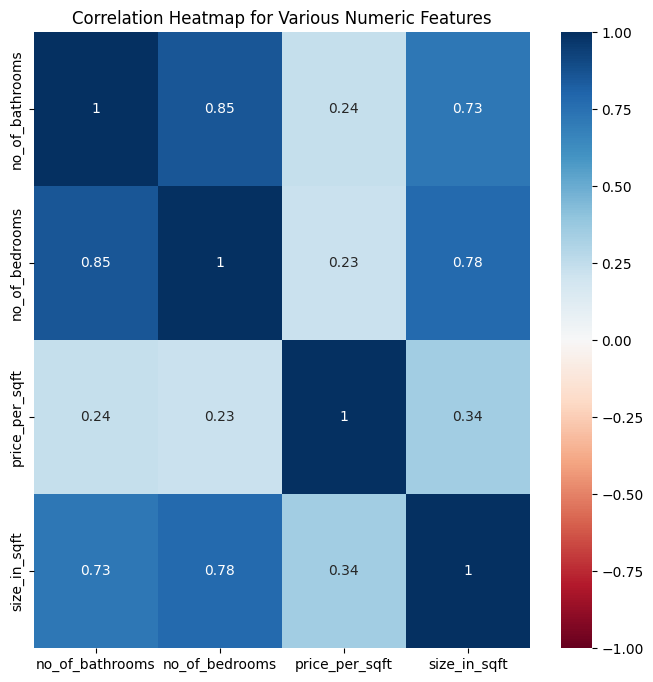

In [17]:
corr_mat = num_df.corr()

plt.figure(figsize=(8,8))
sns.heatmap(corr_mat, annot=True, cmap='RdBu', vmin=-1, vmax=1)
plt.title('Correlation Heatmap for Various Numeric Features')

plt.show()

## **1.3** Feature Engineering

### **1.3.1** Cast Boolean Values into Integers

In [18]:
encoded_df_properties = df_properties.drop(columns=['id', 'latitude', 'longitude', 'neighborhood'])

In [19]:
encoded_df_properties = encoded_df_properties.apply(lambda x : x.astype(int) if x.dtype=='bool' else x)

### **1.3.2** Encode Classes in 'Quality' Column

In [20]:
quality_mapping = {
    'Low': 0,
    'Medium': 1,
    'High': 2,
    'Ultra': 3,
}

encoded_df_properties['quality'] = encoded_df_properties['quality'].apply(lambda x : quality_mapping[x])

In [21]:
encoded_df_properties['quality'].unique()

array([1, 0, 2, 3])

## **1.4** Modeling (sklearn)

### **1.4.1** Preprocessing: Create Features and Label and Split Data into Train and Test

Now that we have explored and cleaned our dataset, let's prepare it for a machine learning task.

In [22]:
features = encoded_df_properties.drop(columns=['quality'])

target = encoded_df_properties['quality']

In [23]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=seed)

### **1.4.2** Classification Models

#### (a) Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(penalty=None, multi_class = 'multinomial')
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

log_acc = classifier.score(X_test, y_test)

log_acc

0.5931758530183727

#### (b) Random Forest Classifier

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

tree_classifier = RandomForestClassifier(class_weight = 'balanced', n_estimators = 120, max_depth = 30, random_state = 42)
tree_classifier.fit(X_train, y_train)

y_pred = tree_classifier.predict(X_test)

rf_acc = tree_classifier.score(X_test, y_test)

rf_confusion = confusion_matrix(y_test, y_pred)

rf_acc, rf_confusion

(0.9212598425196851,
 array([[ 97,  15,   0,   0],
        [  1, 225,   2,   0],
        [  0,  12,  17,   0],
        [  0,   0,   0,  12]]))

#### (c) PCA to Reduce Dimensionality

_**Initial PCA**_

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA()
X_train_pca = pca.fit(X_train_scaled)

_**Cumulative Explained Variance Ratios**_

In [27]:
explained_variance_ratios = pca.explained_variance_ratio_

cum_evr = explained_variance_ratios.cumsum()

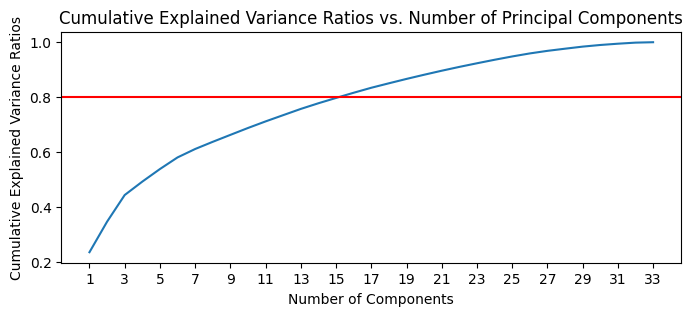

In [28]:
plt.figure(figsize=(8,3))
plt.plot(range(1, len(cum_evr) + 1), cum_evr)
plt.axhline(y=0.8, color='r')

plt.title('Cumulative Explained Variance Ratios vs. Number of Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratios')

plt.xticks(range(1, len(cum_evr) + 1, 2))

plt.show()

_**Final PCA**_

In [29]:
pca = PCA(n_components=16)
pca.fit(X_train_scaled)


X_test_pca = pca.transform(X_test_scaled)
X_train_pca = pca.transform(X_train_scaled)

#### (d) Logistic Regression with PCA

In [30]:
log_reg_pca = LogisticRegression(penalty = None, multi_class = 'multinomial')
log_reg_pca.fit(X_train_pca, y_train)

y_pred = log_reg_pca.predict(X_test_pca)

test_accuracy = log_reg_pca.score(X_test_pca, y_test)

test_accuracy

0.9921259842519685

### **1.4.3.0** Regression: Split Data into Train and Test

In [31]:
reg_df_properties = encoded_df_properties[['price', 'size_in_sqft', 'no_of_bedrooms', 'no_of_bathrooms']]

In [32]:
features = reg_df_properties.drop(columns=['price'])

target = reg_df_properties['price']

In [33]:
seed = 42
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=seed)

### **1.4.3.1** Regression Models

In this section, we will switch from classification models to regression models.

Let's use the features we created in 1.4.3.0 to create regression models and predict the average price per room.

#### (a) Linear Regression (Unregularized)

In [34]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)


lin_reg_score = reg.score(X_test, y_test)

#### (b) Lasso Regression

In [35]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [36]:
from sklearn.linear_model import Lasso

reg_lasso = Lasso(alpha = 0.5)
reg_lasso.fit(X_train_scaled, y_train)

y_pred = reg_lasso.predict(X_test_scaled)

lasso_score = reg_lasso.score(X_test_scaled, y_test)

lasso_score

0.7092097454167732

### **1.4.4** K-Means Clustering

#### (a) Find the best number of clusters with the elbow plot

In [37]:
features = encoded_df_properties.drop(columns=['quality'])

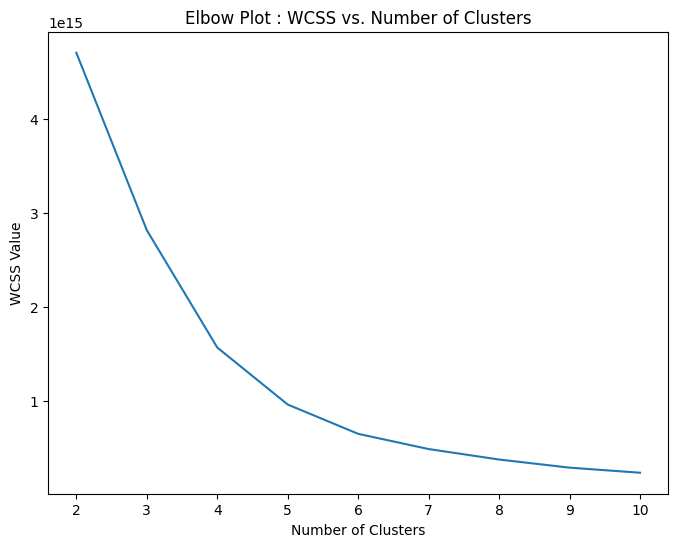

In [38]:
from sklearn.cluster import KMeans

wcss = []

for i in range(2,11):
  kmeans = KMeans(n_clusters = i, n_init = 5, random_state = 0)
  kmeans.fit(features)
  wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,6))
plt.plot(range(2,11), wcss)

plt.title('Elbow Plot : WCSS vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS Value')

plt.show()

In [39]:
number_of_clusters = 5

#### (b) Re-fit with the best number of clusters

In [40]:
kmeans = KMeans(n_clusters=5, n_init=5, random_state=0).fit(features)

# **Part II:** Distributed Machine Learning with Spark

In [41]:
%%capture

!apt install libkrb5-dev
!wget https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz
!tar xf spark-3.1.2-bin-hadoop3.2.tgz
!pip install findspark
!pip install sparkmagic
!pip install pyspark
! pip install pyspark --user
! pip install seaborn --user
! pip install plotly --user
! pip install imageio --user
! pip install folium --user

In [42]:
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

spark = SparkSession.builder.appName('bigdata-hw4').getOrCreate()
sqlContext = SQLContext(spark)

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [43]:
%load_ext sparkmagic.magics

In [44]:
# Graph section
import networkx as nx

# SQLite RDBMS
import sqlite3

import os
os.environ['SPARK_HOME'] = '/content/spark-3.1.2-bin-hadoop3.2'
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

## **2.1** Initializing Spark Data

### **2.1.0** Converting the Pandas Dataframe into a Spark Dataframe

In [45]:
properties_sdf = spark.createDataFrame(encoded_df_properties)

In [46]:
from pyspark.sql.functions import col
properties_sdf = properties_sdf.withColumn('quality', col('quality').cast(DoubleType()))

### **2.1.1** Setting Up a VectorAssembler

In [47]:
all_columns = properties_sdf.columns
print(all_columns)

['price', 'size_in_sqft', 'price_per_sqft', 'no_of_bedrooms', 'no_of_bathrooms', 'quality', 'maid_room', 'unfurnished', 'balcony', 'barbecue_area', 'built_in_wardrobes', 'central_ac', 'childrens_play_area', 'childrens_pool', 'concierge', 'covered_parking', 'kitchen_appliances', 'lobby_in_building', 'maid_service', 'networked', 'pets_allowed', 'private_garden', 'private_gym', 'private_jacuzzi', 'private_pool', 'security', 'shared_gym', 'shared_pool', 'shared_spa', 'study', 'vastu_compliant', 'view_of_landmark', 'view_of_water', 'walk_in_closet']


In [48]:
drop_columns = properties_sdf.drop('quality', 'neighborhood')

In [49]:
feature_columns = drop_columns.columns
print(feature_columns)

['price', 'size_in_sqft', 'price_per_sqft', 'no_of_bedrooms', 'no_of_bathrooms', 'maid_room', 'unfurnished', 'balcony', 'barbecue_area', 'built_in_wardrobes', 'central_ac', 'childrens_play_area', 'childrens_pool', 'concierge', 'covered_parking', 'kitchen_appliances', 'lobby_in_building', 'maid_service', 'networked', 'pets_allowed', 'private_garden', 'private_gym', 'private_jacuzzi', 'private_pool', 'security', 'shared_gym', 'shared_pool', 'shared_spa', 'study', 'vastu_compliant', 'view_of_landmark', 'view_of_water', 'walk_in_closet']


In [50]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

## **2.2** Preprocessing: Pipeline and Train-Test Split


In [51]:
from pyspark.ml import Pipeline

pipeline = Pipeline(stages=[assembler])

processed_properties_sdf = pipeline.fit(properties_sdf).transform(properties_sdf)

Now that we have the data in the format we need, we will create our train and test sets.

In [52]:
random_seed = 42

train_sdf, test_sdf = processed_properties_sdf.randomSplit([0.8, 0.2], seed = random_seed)

## **2.3** Modelling (SparkML)

### **2.3.1** Vanilla Logistic Regression

In [53]:
from pyspark.ml.classification import LogisticRegression

lr_model = LogisticRegression(featuresCol='features', labelCol='quality', maxIter=5, family='multinomial').fit(train_sdf)

In [54]:
train_accuracy = lr_model.summary.accuracy

In [55]:
train_accuracy

0.9406130268199234

Now, let's find out how good the model actually is and see if it overfits to the training data.

In [56]:
predictions = lr_model.transform(test_sdf)

In [57]:
from pyspark.mllib.evaluation import MulticlassMetrics

predictionAndLabels = predictions.select(['prediction', 'quality']).rdd

metrics = MulticlassMetrics(predictionAndLabels)

confusion_matrix = np.array(metrics.confusionMatrix().toArray())

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [58]:
total_correct = confusion_matrix.trace()
total = confusion_matrix.sum()
test_accuracy = total_correct / total
test_accuracy

0.9026548672566371

### **2.3.2** Regularized Logistic Regression

Now, we will add regularization – LASSO (L1), Ridge (L2) and elastic net (combination of L1 and L2), to avoid overfitting.

#### (a) LASSO (L1)

In [59]:
l1_model = LogisticRegression(featuresCol='features', labelCol='quality', regParam = 0.1, elasticNetParam=1, maxIter=5, family='multinomial')

l1_model = l1_model.fit(train_sdf)


l1_train_accuracy = l1_model.summary.accuracy

l1_train_accuracy

0.8320561941251596

In [60]:
predictions = l1_model.transform(test_sdf)
predictionsAndLabels = predictions.select(['prediction', 'quality']).rdd
metrics = MulticlassMetrics(predictionAndLabels)
confusion_matrix_l1 = np.array(metrics.confusionMatrix().toArray())

total_correct = confusion_matrix_l1.trace()
total = confusion_matrix_l1.sum()
l1_test_accuracy = total_correct / total

l1_test_accuracy, confusion_matrix_l1

(0.9026548672566371,
 array([[ 78.,   6.,   0.,   0.],
        [  9., 202.,  11.,   1.],
        [  0.,   4.,  18.,   1.],
        [  0.,   0.,   1.,   8.]]))

#### (b) Ridge (L2)

In [61]:
l2_model = LogisticRegression(featuresCol='features', labelCol='quality', regParam = 0.1, elasticNetParam=0, maxIter=5, family='multinomial')

l2_model = l2_model.fit(train_sdf)

l2_train_accuracy = l2_model.summary.accuracy
l2_train_accuracy

0.9157088122605364

In [62]:
predictions = l2_model.transform(test_sdf)
predictionsAndLabels = predictions.select(['prediction', 'quality']).rdd
metrics = MulticlassMetrics(predictionsAndLabels)
confusion_matrix_l2 = np.array(metrics.confusionMatrix().toArray())

total = confusion_matrix_l2.sum()
total_correct = confusion_matrix_l2.trace()
l2_test_accuracy = total_correct / total
l2_test_accuracy, confusion_matrix_l2

(0.9203539823008849,
 array([[ 73.,  11.,   0.,   0.],
        [  2., 219.,   1.,   1.],
        [  0.,  10.,  12.,   1.],
        [  0.,   0.,   1.,   8.]]))

#### (c) Elastic Net

In [63]:
en_model = LogisticRegression(featuresCol='features', labelCol='quality', regParam = 0.1, elasticNetParam=0.15, maxIter=5, family='multinomial')

en_model = en_model.fit(train_sdf)

en_train_accuracy = en_model.summary.accuracy

en_train_accuracy

0.8908045977011494

In [64]:
predictions = en_model.transform(test_sdf)
predictionsAndLabels = predictions.select(['prediction', 'quality']).rdd
metrics = MulticlassMetrics(predictionsAndLabels)
confusion_matrix_en = np.array(metrics.confusionMatrix().toArray())

total = confusion_matrix_en.sum()
total_correct = confusion_matrix_en.trace()
en_test_accuracy = total_correct / total
en_test_accuracy, confusion_matrix_en

(0.8938053097345132,
 array([[ 71.,  13.,   0.,   0.],
        [  3., 220.,   0.,   0.],
        [  0.,  18.,   4.,   1.],
        [  0.,   0.,   1.,   8.]]))

### **2.3.3** Random Forest Classification

In [65]:
from pyspark.ml.classification import RandomForestClassifier


random_seed = 42
rf = RandomForestClassifier(seed=random_seed, maxDepth=10, labelCol='quality')
rf_model = rf.fit(train_sdf)

In [66]:
train_pred = rf_model.transform(train_sdf)
test_pred = rf_model.transform(test_sdf)

In [73]:
predictionsAndLabels = train_pred.select(['prediction', 'quality']).rdd
metrics = MulticlassMetrics(predictionsAndLabels)
rf_train_cm = np.array(metrics.confusionMatrix().toArray())
total_correct = rf_train_cm.trace()
total = rf_train_cm.sum()
rf_train_accuracy = total_correct / total

predictionsAndLabels = test_pred.select(['prediction', 'quality']).rdd
metrics = MulticlassMetrics(predictionsAndLabels)
rf_test_cm = np.array(metrics.confusionMatrix().toArray())
total_correct = rf_test_cm.trace()
total = rf_test_cm.sum()
rf_test_accuracy = total_correct / total
rf_test_accuracy

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


0.9026548672566371

### **2.3.4** Dimensionality Reduction Using PCA

In [68]:
from pyspark.ml.feature import PCA, StandardScaler

scaler = StandardScaler(inputCol='features', outputCol='scaled_features')
scaler_model = scaler.fit(train_sdf)
train_sdf_scaled = scaler_model.transform(train_sdf)
test_sdf_scaled = scaler_model.transform(test_sdf)

pca = PCA(k=16, inputCol='scaled_features', outputCol='pca_features')
pca_model = pca.fit(train_sdf_scaled)

train_sdf_pca = pca_model.transform(train_sdf_scaled)
test_sdf_pca = pca_model.transform(test_sdf_scaled)

Now, we create a Logistic Regression model and train it using the PCA features.

In [69]:
lr_model = LogisticRegression(featuresCol='features', labelCol='quality', maxIter=5, family='multinomial').fit(train_sdf_pca)

test_pred = lr_model.transform(test_sdf_pca)

In [70]:
train_accuracy_pca = lr_model.summary.accuracy

In [74]:
predictionsAndLabels = test_pred.select(['prediction', 'quality']).rdd
metrics = MulticlassMetrics(predictionsAndLabels)
confusion_matrix_pca = np.array(metrics.confusionMatrix().toArray())

total = confusion_matrix_pca.sum()
total_correct = confusion_matrix_pca.trace()
test_accuracy_pca = total_correct / total
test_accuracy_pca

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


0.9026548672566371